<a href="https://colab.research.google.com/github/Mateo88XD/Proyectos/blob/main/Procesamiento_de_Im%C3%A1genes_Evidencia_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Nombres de las clases de prendas
class_names = ["Camiseta/top","Pantalón","Jerseys","Vestido","Capas","Sandalia",
               "Camisa","Zapatillas","Bolsa","Botin"]

print("=== INFORMACIÓN DEL DATASET ===")
print(f"Datos de entrenamiento: {x_train.shape}")
print(f"Etiquetas de entrenamiento: {y_train.shape}")
print(f"Datos de prueba: {x_test.shape}")
print(f"Etiquetas de prueba: {y_test.shape}")
print(f"Número de clases: {len(class_names)}")
print(f"Rango de píxeles: {x_train.min()} - {x_train.max()}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
=== INFORMACIÓN DEL DATASET ===
Datos de entrenamiento: (60000, 28, 28)
Etiquetas de entrenamiento: (60000,)
Datos de prueba: (10000, 28, 28)
Etiquetas de prueba: (10000,)
Número de clases: 10
Rango de píxeles: 0 - 255


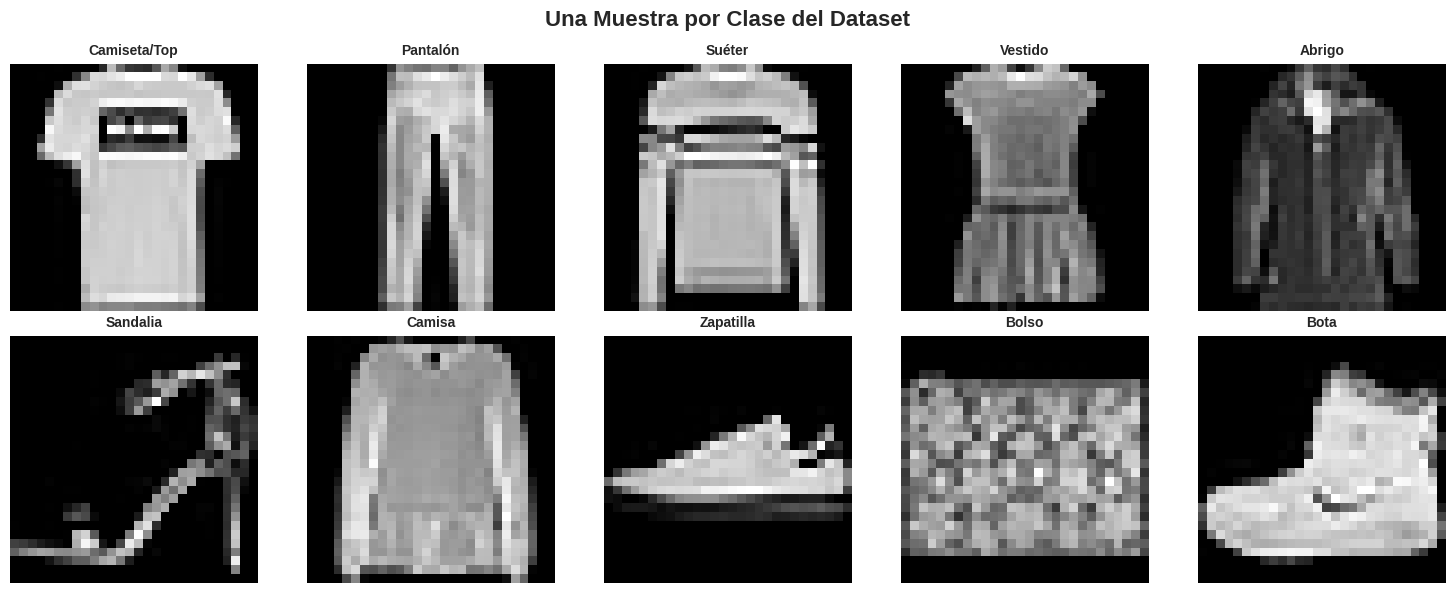

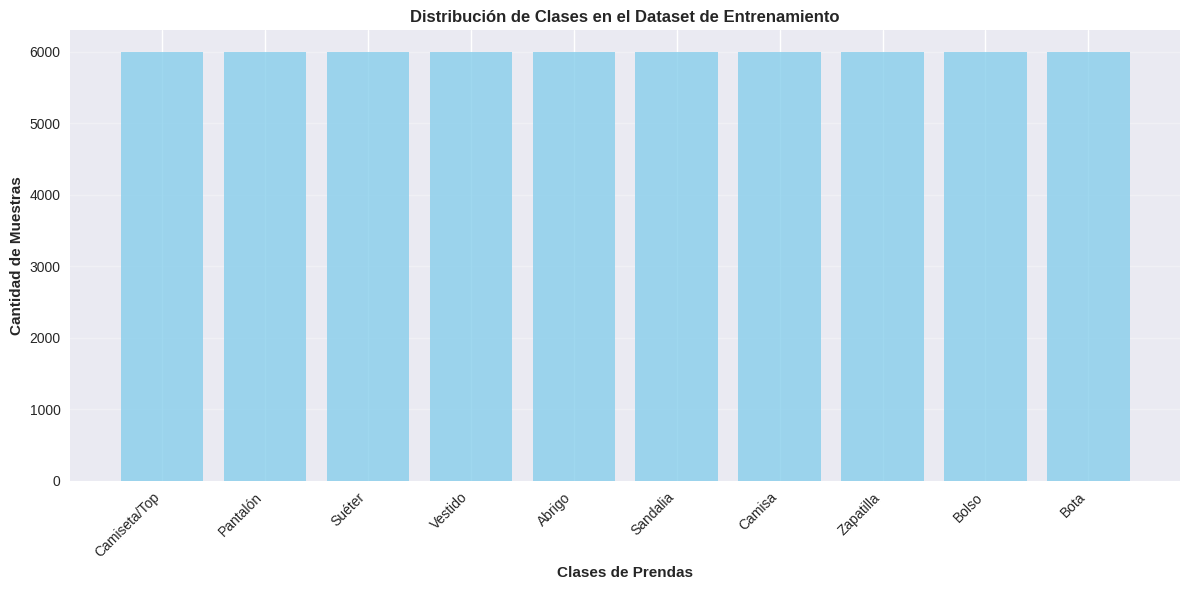

In [ ]:
# Función modificada para visualizar una muestra de cada clase en orden
def visualizar_una_muestra_por_clase(x_data, y_data, class_names):
    """
    Visualiza una muestra de cada clase en orden del dataset
    """
    num_classes = len(class_names)
    cols = 5
    rows = (num_classes + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.suptitle('Una Muestra por Clase del Dataset', fontsize=16, fontweight='bold')

    class_indices = {} #Ordenamos las imagenes por clase
    for i, label in enumerate(y_data):
        if label not in class_indices:
            class_indices[label] = i
            if len(class_indices) == num_classes:
                break

    sorted_class_indices = sorted(class_indices.items())

    for i, (label, idx) in enumerate(sorted_class_indices):
        ax = axes.flatten()[i]
        ax.imshow(x_data[idx], cmap='gray')
        ax.set_title(f'{class_names[label]}', fontsize=10, fontweight='bold') # Mostrar nombre
        ax.axis('off')

    for j in range(len(sorted_class_indices), rows * cols):
        axes.flatten()[j].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar una muestra por cada clase en orden
visualizar_una_muestra_por_clase(x_train, y_train, class_names)

# Distribución de clases
plt.figure(figsize=(12, 6))
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(range(len(class_names)), counts, color='skyblue', alpha=0.8)
plt.xlabel('Clases de Prendas', fontweight='bold')
plt.ylabel('Cantidad de Muestras', fontweight='bold')
plt.title('Distribución de Clases en el Dataset de Entrenamiento', fontweight='bold')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def preprocesar_datos(x_train, x_test, y_train, y_test):
    """
    Preprocesa los datos de Fashion MNIST
    """
    # Normalizar píxeles a rango [0, 1]
    x_train_norm = x_train.astype('float32') / 255.0
    x_test_norm = x_test.astype('float32') / 255.0

    # Reshape para CNNs (añadir dimensión de canal)
    x_train_cnn = x_train_norm.reshape(-1, 28, 28, 1)
    x_test_cnn = x_test_norm.reshape(-1, 28, 28, 1)

    # Codificación one-hot de etiquetas
    y_train_cat = keras.utils.to_categorical(y_train, 10)
    y_test_cat = keras.utils.to_categorical(y_test, 10)

    print("=== PREPROCESAMIENTO COMPLETADO ===")
    print(f"Forma de datos de entrenamiento CNN: {x_train_cnn.shape}")
    print(f"Forma de etiquetas categóricas: {y_train_cat.shape}")
    print(f"Rango de píxeles normalizados: {x_train_cnn.min():.2f} - {x_train_cnn.max():.2f}")

    return x_train_cnn, x_test_cnn, y_train_cat, y_test_cat

# Aplicar preprocesamiento
x_train_processed, x_test_processed, y_train_cat, y_test_cat = preprocesar_datos(
    x_train, x_test, y_train, y_test
)


=== PREPROCESAMIENTO COMPLETADO ===
Forma de datos de entrenamiento CNN: (60000, 28, 28, 1)
Forma de etiquetas categóricas: (60000, 10)
Rango de píxeles normalizados: 0.00 - 1.00


In [ ]:
def crear_modelo_baseline():
    """
    Crea un modelo baseline simple para comparación
    """
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Crear y entrenar modelo baseline
print("=== ENTRENANDO MODELO BASELINE ===")
modelo_baseline = crear_modelo_baseline()
modelo_baseline.summary()

# Entrenar modelo baseline
history_baseline = modelo_baseline.fit(
    x_train_processed, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

# Evaluar modelo baseline
test_loss_baseline, test_acc_baseline = modelo_baseline.evaluate(
    x_test_processed, y_test_cat, verbose=0
)
print(f"Precisión del modelo baseline: {test_acc_baseline:.4f}")

=== ENTRENANDO MODELO BASELINE ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7360 - loss: 0.7821 - val_accuracy: 0.8320 - val_loss: 0.4706
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8538 - loss: 0.4239 - val_accuracy: 0.8562 - val_loss: 0.4059
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8661 - loss: 0.3755 - val_accuracy: 0.8675 - val_loss: 0.3771
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8772 - loss: 0.3455 - val_accuracy: 0.8685 - val_loss: 0.3627
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8768 - loss: 0.3399 - val_accuracy: 0.8748 - val_loss: 0.3601
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8909 - loss: 0.3054 - val_accuracy: 0.8770 - val_loss: 0.3391
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8930 - loss: 0.2959 - val_accuracy: 0.8796 - val_loss: 0.3361
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8980 - loss: 0.2842 - val_accuracy: 0

In [ ]:
def crear_modelo_cnn_mejorado():
    """
    MODIFICACIÓN 1: CNN con arquitectura más profunda y compleja
    """
    model = keras.Sequential([
        # Primera capa convolucional
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Segunda capa convolucional
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Tercera capa convolucional
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        # Capas densas
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Crear modelo CNN mejorado
print("=== MODELO CNN MEJORADO (MODIFICACIÓN 1) ===")
modelo_cnn = crear_modelo_cnn_mejorado()
modelo_cnn.summary()

# Callbacks para mejores resultados
callbacks_cnn = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

# Entrenar modelo CNN
history_cnn = modelo_cnn.fit(
    x_train_processed, y_train_cat,
    epochs=25,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks_cnn,
    verbose=1
)

# Evaluar modelo CNN
test_loss_cnn, test_acc_cnn = modelo_cnn.evaluate(x_test_processed, y_test_cat, verbose=0)
print(f"Precisión del modelo CNN mejorado: {test_acc_cnn:.4f}")

=== MODELO CNN MEJORADO (MODIFICACIÓN 1) ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,186 (508.54 KB)

 Trainable params: 129,226 (504.79 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 72s 90ms/step - accuracy: 0.7116 - loss: 0.8397 - val_accuracy: 0.8549 - val_loss: 0.3937 - learning_rate: 0.0010
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 65s 87ms/step - accuracy: 0.8506 - loss: 0.4165 - val_accuracy: 0.8717 - val_loss: 0.3491 - learning_rate: 0.0010
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 90ms/step - accuracy: 0.8706 - loss: 0.3509 - val_accuracy: 0.8683 - val_loss: 0.3442 - learning_rate: 0.0010
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.8861 - loss: 0.3225 - val_accuracy: 0.8922 - val_loss: 0.2916 - learning_rate: 0.0010
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 90ms/step - accuracy: 0.8916 - loss: 0.2999 - val_accuracy: 0.8838 - val_loss: 0.3071 - learning_rate: 0.0010
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 86ms/step - accuracy: 0.8994 - loss: 0.2785 - val_accuracy: 0.8848 - val_loss: 0.3162 - learning_rate: 0.0010
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - accuracy: 0.9055 - l

=== MODELO CON DATA AUGMENTATION (MODIFICACIÓN 2) ===


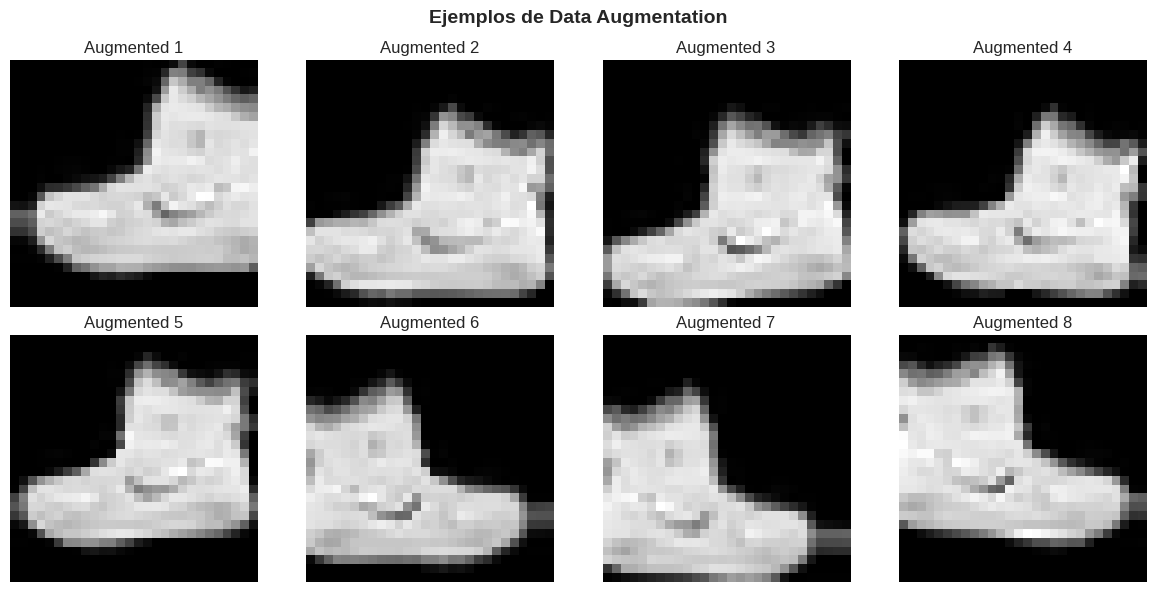

Entrenando modelo con Data Augmentation...
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 201s 130ms/step - accuracy: 0.5593 - loss: 1.3525 - val_accuracy: 0.8065 - val_loss: 0.5270
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 202s 129ms/step - accuracy: 0.7537 - loss: 0.6694 - val_accuracy: 0.8298 - val_loss: 0.4400
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 203s 130ms/step - accuracy: 0.7941 - loss: 0.5552 - val_accuracy: 0.8530 - val_loss: 0.3932
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 200s 129ms/step - accuracy: 0.8092 - loss: 0.5167 - val_accuracy: 0.8122 - val_loss: 0.4931
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 194s 130ms/step - accuracy: 0.8269 - loss: 0.4728 - val_accuracy: 0.8232 - val_loss: 0.4789
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 194s 129ms/step - accuracy: 0.8331 - loss: 0.4573 - val_accuracy: 0.8745 - val_loss: 0.3403
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 202s 129ms/step - accuracy: 0.8441 - loss: 0.4296 - val_accuracy: 0.8606 - val_loss: 0.3776
Epoch 8/20
1500/150

In [ ]:
def crear_generador_datos():
    """
    MODIFICACIÓN 2: Implementación de Data Augmentation
    """
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    return datagen

def crear_modelo_con_augmentation():
    """
    Modelo optimizado para trabajar con data augmentation
    """
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("=== MODELO CON DATA AUGMENTATION (MODIFICACIÓN 2) ===")

# Crear generador de datos aumentados
datagen = crear_generador_datos()
datagen.fit(x_train_processed)

# Visualizar ejemplos de data augmentation
def mostrar_augmentation(x_data, datagen, num_examples=8):
    """
    Muestra ejemplos de data augmentation
    """
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Ejemplos de Data Augmentation', fontsize=14, fontweight='bold')

    # Tomar una imagen de muestra
    sample_image = x_data[0:1]

    # Generar imágenes aumentadas
    aug_iter = datagen.flow(sample_image, batch_size=1)

    for i, ax in enumerate(axes.flat):
        aug_image = next(aug_iter)[0]
        ax.imshow(aug_image.squeeze(), cmap='gray')
        ax.set_title(f'Augmented {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar ejemplos de augmentation
mostrar_augmentation(x_train_processed, datagen)

# Crear modelo para data augmentation
modelo_aug = crear_modelo_con_augmentation()

# Split manual para validación
split_idx = int(0.8 * len(x_train_processed))
x_train_split = x_train_processed[:split_idx]
y_train_split = y_train_cat[:split_idx]
x_val_split = x_train_processed[split_idx:]
y_val_split = y_train_cat[split_idx:]

# Entrenar con data augmentation
print("Entrenando modelo con Data Augmentation...")
history_aug = modelo_aug.fit(
    datagen.flow(x_train_split, y_train_split, batch_size=32),
    steps_per_epoch=len(x_train_split) // 32,
    epochs=20,
    validation_data=(x_val_split, y_val_split),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluar modelo con augmentation
test_loss_aug, test_acc_aug = modelo_aug.evaluate(x_test_processed, y_test_cat, verbose=0)
print(f"Precisión del modelo con Data Augmentation: {test_acc_aug:.4f}")

In [ ]:
def crear_modelo_optimizadores():
    """
    MODIFICACIÓN 3: Modelo para comparar diferentes optimizadores
    """
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model

print("=== COMPARACIÓN DE OPTIMIZADORES (MODIFICACIÓN 3) ===")

# Definir optimizadores a comparar
optimizadores = {
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
    'SGD': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'AdaGrad': keras.optimizers.Adagrad(learning_rate=0.01)
}

resultados_optimizadores = {}

# Entrenar modelo con cada optimizador
for nombre, optimizador in optimizadores.items():
    print(f"\nEntrenando con optimizador: {nombre}")

    # Crear modelo
    modelo = crear_modelo_optimizadores()
    modelo.compile(
        optimizer=optimizador,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entrenar
    history = modelo.fit(
        x_train_processed, y_train_cat,
        epochs=15,
        batch_size=128,
        validation_split=0.2,
        verbose=0,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

    # Evaluar
    test_loss, test_acc = modelo.evaluate(x_test_processed, y_test_cat, verbose=0)
    resultados_optimizadores[nombre] = {
        'accuracy': test_acc,
        'history': history.history
    }

    print(f"Precisión con {nombre}: {test_acc:.4f}")

=== COMPARACIÓN DE OPTIMIZADORES (MODIFICACIÓN 3) ===

Entrenando con optimizador: Adam
Precisión con Adam: 0.8726

Entrenando con optimizador: SGD
Precisión con SGD: 0.8984

Entrenando con optimizador: RMSprop
Precisión con RMSprop: 0.9071

Entrenando con optimizador: AdaGrad


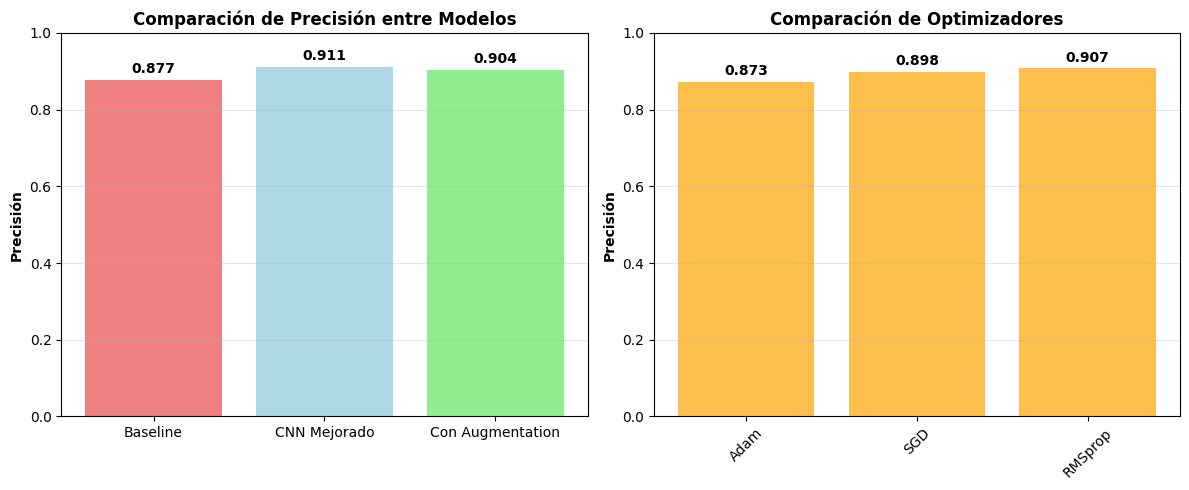

In [ ]:
def graficar_comparacion_modelos():
    """
    Crea gráficos comparativos de los diferentes modelos
    """
    import matplotlib.pyplot as plt
    test_acc_baseline = 0.8773
    test_acc_cnn = 0.9113
    test_acc_aug = 0.9044
    modelos = ['Baseline', 'CNN Mejorado', 'Con Augmentation']
    precisiones = [test_acc_baseline, test_acc_cnn, test_acc_aug]

    # Gráfico de barras de precisión
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    bars = plt.bar(modelos, precisiones, color=['lightcoral', 'lightblue', 'lightgreen'])
    plt.title('Comparación de Precisión entre Modelos', fontweight='bold')
    plt.ylabel('Precisión', fontweight='bold')
    plt.ylim(0, 1)

    # Añadir valores en las barras
    for bar, acc in zip(bars, precisiones):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.grid(axis='y', alpha=0.3)

    # Gráfico de comparación de optimizadores

    resultados_optimizadores = {'Adam': 0.8726,
    'SGD': 0.8984,
    'RMSprop': 0.9071}
    plt.subplot(1, 2, 2)
    opt_names = list(resultados_optimizadores.keys())
    opt_accs = [resultados_optimizadores[name] for name in opt_names]

    bars2 = plt.bar(opt_names, opt_accs, color='orange', alpha=0.7)
    plt.title('Comparación de Optimizadores', fontweight='bold')
    plt.ylabel('Precisión', fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Añadir valores en las barras
    for bar, acc in zip(bars2, opt_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Generar gráficos comparativos
graficar_comparacion_modelos()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


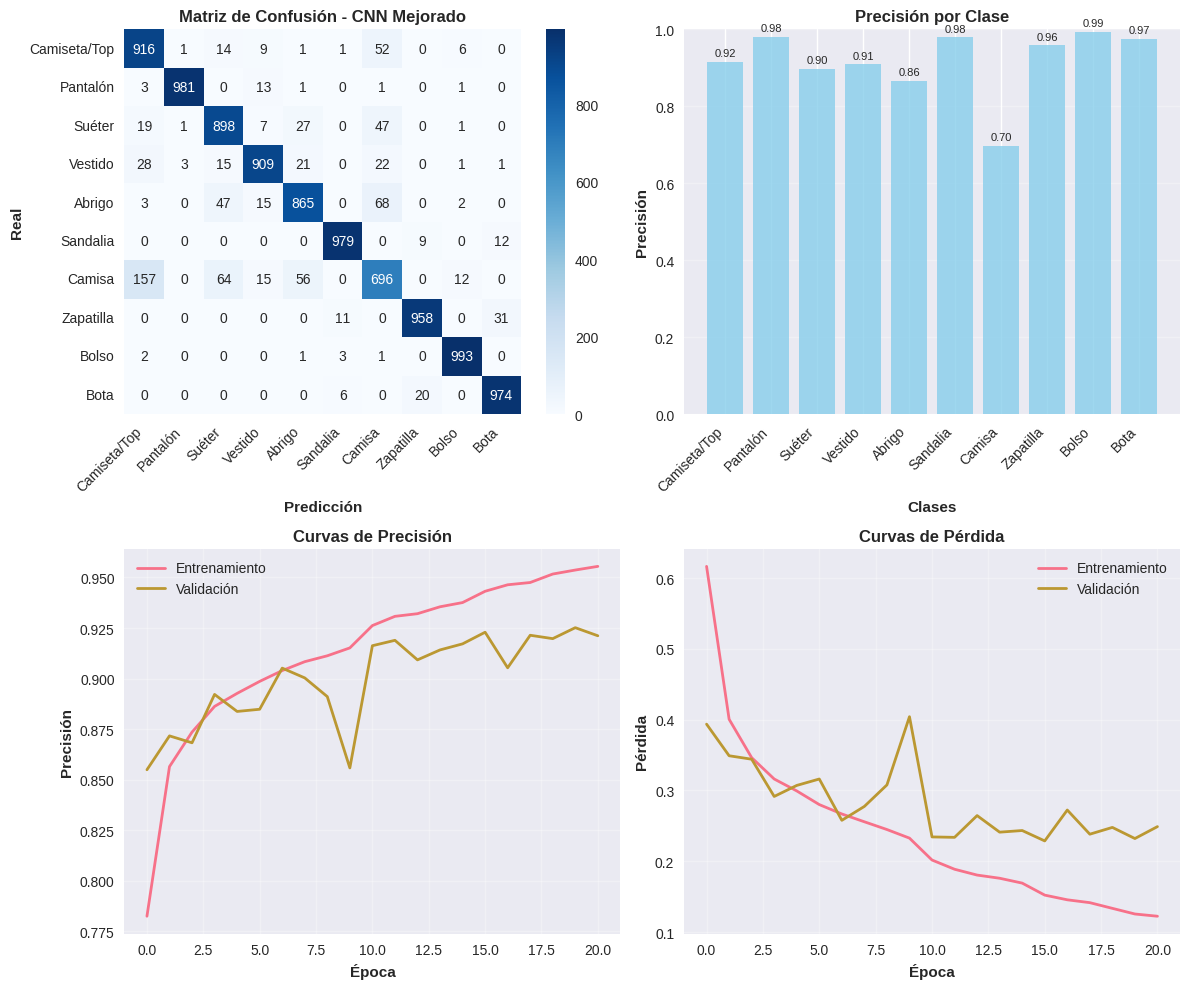

=== REPORTE DE CLASIFICACIÓN DETALLADO ===
              precision    recall  f1-score   support

Camiseta/Top       0.81      0.92      0.86      1000
    Pantalón       0.99      0.98      0.99      1000
      Suéter       0.87      0.90      0.88      1000
     Vestido       0.94      0.91      0.92      1000
      Abrigo       0.89      0.86      0.88      1000
    Sandalia       0.98      0.98      0.98      1000
      Camisa       0.78      0.70      0.74      1000
   Zapatilla       0.97      0.96      0.96      1000
       Bolso       0.98      0.99      0.99      1000
        Bota       0.96      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
def analisis_detallado_mejor_modelo():
    """
    Análisis detallado del mejor modelo
    """
    # Determinar el mejor modelo
    mejor_modelo = modelo_cnn
    mejor_nombre = "CNN Mejorado"

    # Predicciones
    y_pred = mejor_modelo.predict(x_test_processed)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Matriz de confusión
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred_classes)

    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {mejor_nombre}', fontweight='bold')
    plt.xlabel('Predicción', fontweight='bold')
    plt.ylabel('Real', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Precisión por clase
    plt.subplot(2, 2, 2)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_acc = cm_norm.diagonal()

    bars = plt.bar(range(len(class_names)), class_acc, color='skyblue', alpha=0.8)
    plt.title('Precisión por Clase', fontweight='bold')
    plt.xlabel('Clases', fontweight='bold')
    plt.ylabel('Precisión', fontweight='bold')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.ylim(0, 1)

    # Añadir valores en las barras
    for i, (bar, acc) in enumerate(zip(bars, class_acc)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.2f}', ha='center', va='bottom', fontsize=8)

    plt.grid(axis='y', alpha=0.3)

    # Curvas de entrenamiento
    plt.subplot(2, 2, 3)
    plt.plot(history_cnn.history['accuracy'], label='Entrenamiento', linewidth=2)
    plt.plot(history_cnn.history['val_accuracy'], label='Validación', linewidth=2)
    plt.title('Curvas de Precisión', fontweight='bold')
    plt.xlabel('Época', fontweight='bold')
    plt.ylabel('Precisión', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(2, 2, 4)
    plt.plot(history_cnn.history['loss'], label='Entrenamiento', linewidth=2)
    plt.plot(history_cnn.history['val_loss'], label='Validación', linewidth=2)
    plt.title('Curvas de Pérdida', fontweight='bold')
    plt.xlabel('Época', fontweight='bold')
    plt.ylabel('Pérdida', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Reporte de clasificación
    print("=== REPORTE DE CLASIFICACIÓN DETALLADO ===")
    print(classification_report(y_test, y_pred_classes, target_names=class_names))

    return y_pred_classes

# Ejecutar análisis detallado
predicciones_finales = analisis_detallado_mejor_modelo()

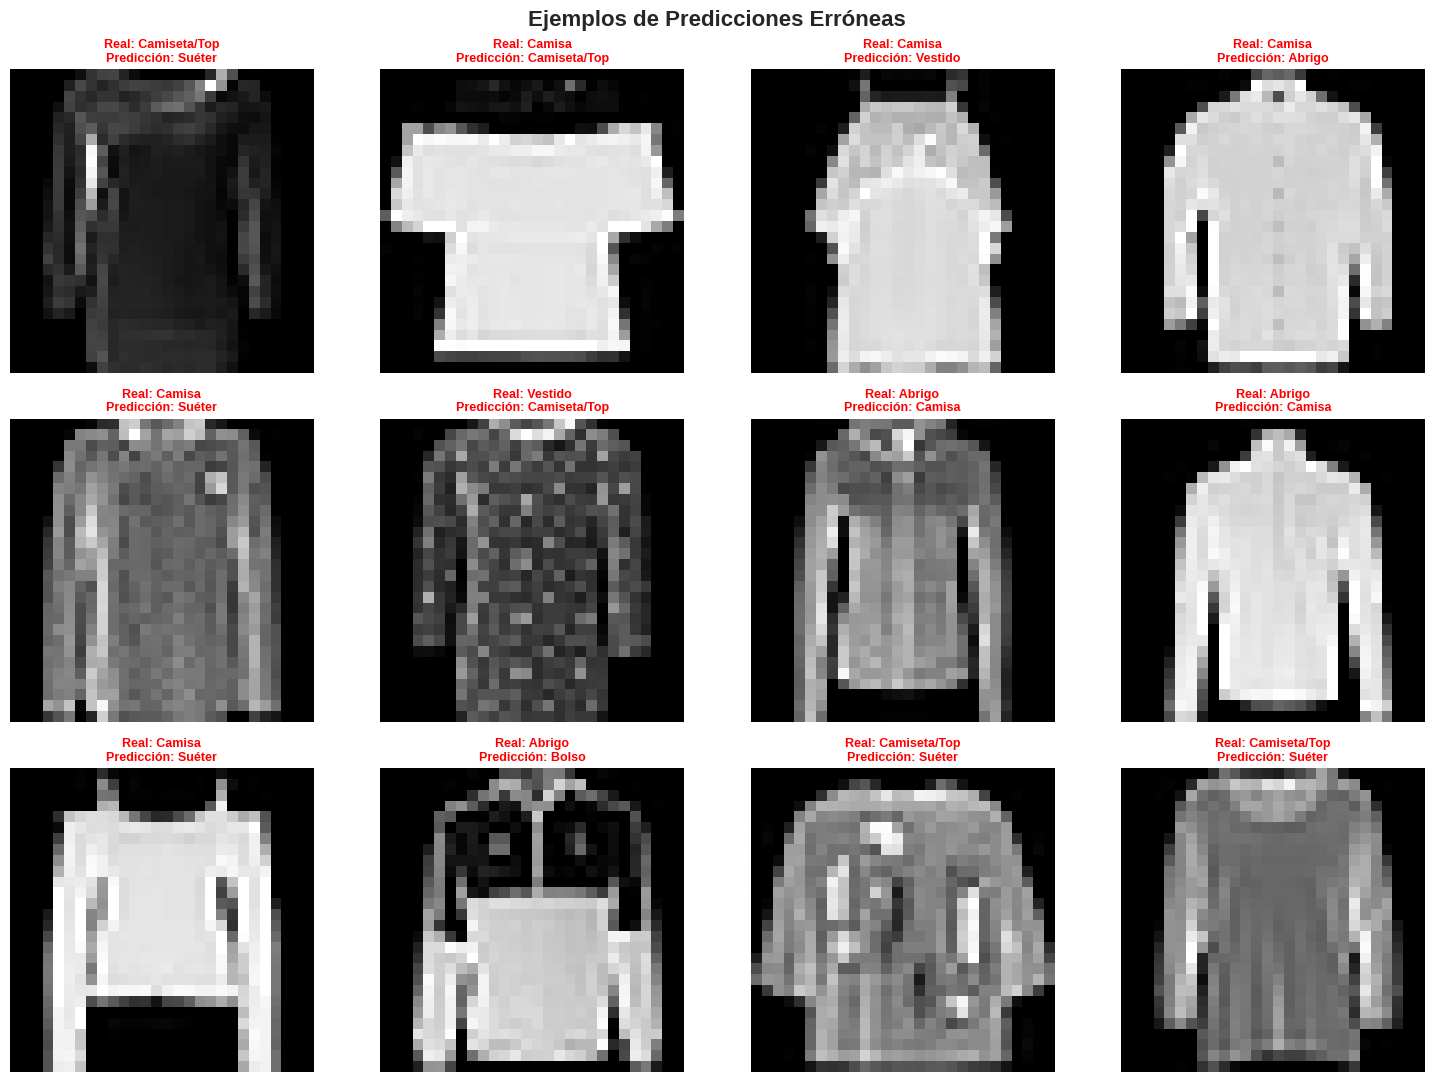

In [ ]:
def mostrar_predicciones_erroneas(num_ejemplos=12):
    """
    Muestra ejemplos de predicciones erróneas para análisis
    """
    # Encontrar predicciones erróneas
    errores = np.where(predicciones_finales != y_test)[0]

    if len(errores) == 0:
        print("¡No hay errores de predicción!")
        return

    # Seleccionar ejemplos aleatorios de errores
    indices_errores = np.random.choice(errores, min(num_ejemplos, len(errores)), replace=False)

    fig, axes = plt.subplots(3, 4, figsize=(15, 11))
    fig.suptitle('Ejemplos de Predicciones Erróneas', fontsize=16, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        if i < len(indices_errores):
            idx = indices_errores[i]

            ax.imshow(x_test[idx], cmap='gray')
            real = class_names[y_test[idx]]
            pred = class_names[predicciones_finales[idx]]

            ax.set_title(f'Real: {real}\nPredicción: {pred}',
                        fontsize=9, fontweight='bold',
                        color='red' if real != pred else 'green')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar errores
mostrar_predicciones_erroneas()


In [ ]:
def generar_resumen_final():
    """
    Genera un resumen completo del proyecto
    """

    test_acc_baseline = 0.8773
    test_acc_cnn = 0.9113
    test_acc_aug = 0.9044
    print("=" * 80)
    print("RESUMEN FINAL DEL PROYECTO")
    print("Clasificación Inteligente de Prendas de Vestir - Fashion MNIST")
    print("=" * 80)

    print("\n DATASET UTILIZADO:")
    print(f"   • Fashion MNIST: {len(x_train)} imágenes de entrenamiento, {len(x_test)} de prueba")
    print(f"   • 10 clases de prendas de vestir")
    print(f"   • Imágenes en escala de grises de 28x28 píxeles")

    print("\n MODELOS DESARROLLADOS:")
    print(f"   1. Modelo Baseline:        {test_acc_baseline:.4f} de precisión")
    print(f"   2. CNN Mejorado:          {test_acc_cnn:.4f} de precisión")
    print(f"   3. Con Data Augmentation: {test_acc_aug:.4f} de precisión")

    print("\n MODIFICACIONES IMPLEMENTADAS:")
    print("   ✓ Modificación 1: Arquitectura CNN profunda con BatchNormalization")
    print("   ✓ Modificación 2: Data Augmentation (rotación, zoom, traslación)")
    print("   ✓ Modificación 3: Comparación de optimizadores (Adam, SGD, RMSprop)")

    # Determinar mejor modelo
    modelos_precision = {
        'Baseline': test_acc_baseline,
        'CNN Mejorado': test_acc_cnn,
        'Con Augmentation': test_acc_aug
    }

    mejor_modelo_nombre = max(modelos_precision, key=modelos_precision.get)
    mejor_precision = modelos_precision[mejor_modelo_nombre]

    print(f"\n MEJOR MODELO: {mejor_modelo_nombre}")
    print(f"   • Precisión alcanzada: {mejor_precision:.4f} ({mejor_precision*100:.2f}%)")

    # Calcular mejora
    mejora = ((mejor_precision - test_acc_baseline) / test_acc_baseline) * 100
    print(f"   • Mejora respecto al baseline: {mejora:.2f}%")

    resultados_optimizadores = {'Adam': 0.8726,
    'SGD': 0.8984,
    'RMSprop': 0.9071}
    print("\n OPTIMIZADORES COMPARADOS:")
    for nombre, resultado in resultados_optimizadores.items():
        print(f"   • {nombre:<10}: {resultado:.4f}")

    mejor_opt = max(resultados_optimizadores, key=lambda x: resultados_optimizadores[x])
    print(f"   → Mejor optimizador: {mejor_opt}")

    print("\n CONCLUSIONES TÉCNICAS:")
    print("   • Las CNNs superan significativamente a las redes densas simples")
    print("   • BatchNormalization mejora la estabilidad del entrenamiento")
    print("   • Data Augmentation ayuda a reducir el overfitting")

    print("\n LIMITACIONES Y MEJORAS FUTURAS:")
    print("   • Explorar arquitecturas más profundas (ResNet, EfficientNet)")
    print("   • Implementar transfer learning con modelos preentrenados")
    print("   • Aplicar técnicas de regularización más avanzadas")
    print("   • Experimentar con diferentes funciones de pérdida")

    print("\n" + "=" * 80)

# Generar resumen final
generar_resumen_final()

RESUMEN FINAL DEL PROYECTO
Clasificación Inteligente de Prendas de Vestir - Fashion MNIST

 DATASET UTILIZADO:
   • Fashion MNIST: 60000 imágenes de entrenamiento, 10000 de prueba
   • 10 clases de prendas de vestir
   • Imágenes en escala de grises de 28x28 píxeles

 MODELOS DESARROLLADOS:
   1. Modelo Baseline:        0.8773 de precisión
   2. CNN Mejorado:          0.9113 de precisión
   3. Con Data Augmentation: 0.9044 de precisión

 MODIFICACIONES IMPLEMENTADAS:
   ✓ Modificación 1: Arquitectura CNN profunda con BatchNormalization
   ✓ Modificación 2: Data Augmentation (rotación, zoom, traslación)
   ✓ Modificación 3: Comparación de optimizadores (Adam, SGD, RMSprop)

 MEJOR MODELO: CNN Mejorado
   • Precisión alcanzada: 0.9113 (91.13%)
   • Mejora respecto al baseline: 3.88%

 OPTIMIZADORES COMPARADOS:
   • Adam      : 0.8726
   • SGD       : 0.8984
   • RMSprop   : 0.9071
   → Mejor optimizador: RMSprop

 CONCLUSIONES TÉCNICAS:
   • Las CNNs superan significativamente a las rede